In [1]:
import pickle
import sys
import glob
import yaml
from copy import deepcopy
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.edges.atomic import add_atomic_edges, add_bond_order, add_ring_status 
from graphein.protein.edges.distance import node_coords
import torch
import torch_geometric
from torch_geometric.data import Data
import networkx as nx

To use the Graphein submodule graphein.protein.features.sequence.embeddings, you need to install: biovec 
biovec cannot be installed via conda
To use the Graphein submodule graphein.protein.visualisation, you need to install: pytorch3d 
To do so, use the following command: conda install -c pytorch3d pytorch3d


[10/11/22 11:35:35] WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        ]8;id=135367;file:///home/u1/jgaiser/.conda/envs/graphein-env/lib/python3.10/site-packages/graphein/protein/meshes.py\meshes.py]8;;\:]8;id=290677;file:///home/u1/jgaiser/.conda/envs/graphein-env/lib/python3.10/site-packages/graphein/protein/meshes.py#29\29]8;;\
                             install: pytorch3d                                                                    
                             To do so, use the following command: conda install -c pytorch3d pytorch3d             

In [2]:
with open('config.yaml', 'r') as config_file:  
  config = yaml.safe_load(config_file) 

with open(config['protein_config_file'], 'r') as config_file:  
  protein_config = yaml.safe_load(config_file)

protein_atom_labels = protein_config['atom_labels']
protein_edge_labels = protein_config['edge_labels']
interaction_labels = protein_config['interaction_labels']

graphein_param_dict = {"granularity": "atom", 
                       "edge_construction_functions": [add_atomic_edges, add_bond_order, add_ring_status],
                       "deprotonate": False}

graphein_config = ProteinGraphConfig(**graphein_param_dict)

In [3]:
def get_distance(x,y):
    total = 0 

    for a,b in zip(x,y):
        total += (a-b)**2

    return total**(0.5)

def generate_node(node_type_list, node_type, coords):
    feature_vec = [0 for x in range(len(node_type_list))]
    feature_vec[node_type_list.index(node_type)] = 1
    feature_vec.extend(coords)
    return feature_vec

def generate_edge(edge_feature_list, edge_features, weight):
    feature_vec = [0 for x in range(len(edge_feature_list))]
    
    for item in edge_features:
        feature_vec[edge_feature_list.index(item)] = 1
        
    feature_vec.append(weight)
    return feature_vec

In [4]:
pdb_dir = sorted(glob.glob(config['processed_pdbbind_dir'] + "*/"))
voxel_graph_dir = config['voxel_graph_dir']

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random

In [6]:
print(random.randint(0, 5000))

880


Output()

../../data/processed_pdbbind/1b8o/
{'hbond_a': [(20.068, 89.702, 74.626), (18.859, 86.764, 74.862), (19.895, 87.071, 72.458), (23.662, 91.548, 72.946), (26.552, 90.796, 72.207)], 'hbond_d': [(19.088, 89.9, 74.5), (18.543, 86.564, 75.735), (26.651, 88.304, 71.75), (24.141, 92.46, 72.951), (21.043, 90.921, 77.125)], 'pistack': [(24.505666666666666, 88.979, 72.3675)]}


SystemExit: 

/home/u1/jgaiser/.conda/envs/graphein-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3386: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


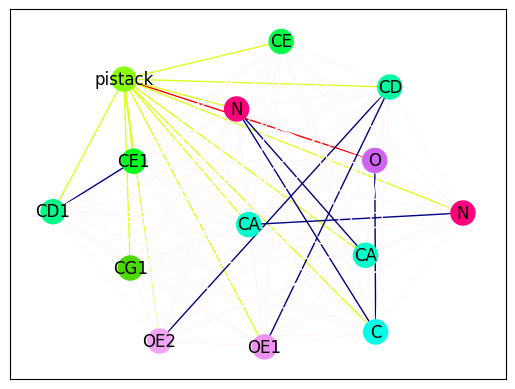

In [24]:
target_id_list = []
voxel_graph_list = []

INTERACTION = 'pistack'

for t_idx, target_dir in enumerate(pdb_dir):
    if t_idx < random.randint(0,5000):
        continue 
        
    if t_idx % 100 == 0:
        print(t_idx)

    target_id = target_dir.split('/')[-2]
    protein_atom_data = []         

    ip_data = pickle.load(open("%s%s_ip.pkl" % (target_dir, target_id), 'rb'))
    
    if INTERACTION not in ip_data:
        continue
    
    print(target_dir)
    print(ip_data)
    
    if len(ip_data) == 0:
        continue 
    
    protein_graph = construct_graph(config=graphein_config, pdb_path="%s%s_protein_25.pdb" % (target_dir, target_id))

    for interaction_type, interaction_coords in ip_data.items():
        if interaction_type != INTERACTION:
            continue 
            
        for interaction_xyz in interaction_coords: 
            target_id_list.append(target_id)
            sorted_nodelist = [['DUMMY', 'DUMMY', interaction_xyz, 0]]
            sorted_node_labels = []
            node_features = []

            edge_features = []
            edge_index = [[],[]]

            for i, n in enumerate(protein_graph.nodes(data=True)):
                n = [n[0], n[1]['atom_type'], n[1]['coords'], get_distance(interaction_xyz, n[1]['coords'])]
                sorted_nodelist.append(n)

            sorted_nodelist = sorted(sorted_nodelist, key=lambda x: x[-1])[:14]
            
            edge_check = [[0 for x in sorted_nodelist] for y in sorted_nodelist]

            for item in sorted_nodelist:
                sorted_node_labels.append(item[0])
                node_features.append(generate_node(protein_atom_labels, item[1], item[2]))

            for i,e in enumerate(protein_graph.edges(data=True)):
                if e[0] not in sorted_node_labels:
                    continue

                if e[1] not in sorted_node_labels:
                    continue
                    
                n1 = sorted_node_labels.index(e[0])
                n2 = sorted_node_labels.index(e[1])

                edge_index[0].extend([n1,n2])
                edge_index[1].extend([n2,n1])
                
                edge_check[n1][n2] = 1
                edge_check[n2][n1] = 1
                
                edge_feature_vec = generate_edge(protein_edge_labels, e[2]['kind'], e[2]['distance'])
                edge_features.extend([edge_feature_vec, edge_feature_vec])
                
            for n1 in range(len(edge_check)):
                for n2 in range(len(edge_check)):
                    if n1 == n2:
                        continue
                        
                    if n1==0 or n2==0:
                        edge_type = 'interaction'
                    else:
                        edge_type = 'spatial'
                        
                    if edge_check[n1][n2] == 0:
                        edge_index[0].extend([n1,n2])
                        edge_index[1].extend([n2,n1])

                        edge_check[n1][n2] = 1
                        edge_check[n2][n1] = 1

                        node_distance = get_distance(node_features[n1][-3:], node_features[n2][-3:])

                        edge_feature_vec = generate_edge(protein_edge_labels, [edge_type], node_distance)
                        edge_features.extend([edge_feature_vec, edge_feature_vec])
                        
            edge_index = torch.tensor(edge_index, dtype=torch.long)
            node_features = torch.tensor(node_features, dtype=torch.float)
            edge_features = torch.tensor(edge_features, dtype=torch.float)
                
            data = Data(x=node_features, edge_index=edge_index, 
                        edge_attr=edge_features, y=interaction_labels.index(interaction_type))
            
            voxel_graph_list.append(data)
            
            g = torch_geometric.utils.to_networkx(data, to_undirected=True)
                
            ### --- DRAW GRAPH --- ###
            node_colormap = cm.get_cmap('gist_ncar')(np.linspace(0, 1, len(protein_atom_labels)))
            edge_colormap = cm.get_cmap('gist_ncar')(np.linspace(0, 1, 3))
            node_labels = {}
            node_colors = []
            edge_colors = []
            edge_labels = {}
            
            for i,n in enumerate(data.x):
                node_cat = torch.where(n[:-3] == 1)[0].item()
                node_labels[i] = protein_atom_labels[node_cat]
                node_colors.append(node_colormap[node_cat])
                
            node_labels[0] = interaction_labels[data.y]
            
            for i,e in enumerate(g.edges):
                a = torch.where(data.edge_index[0] == e[0])
                b = torch.where(data.edge_index[1] == e[1])
                edge_idx = 0
                    
                for idx in a[0]:
                    found=False
                    if idx in b[0]:
                        edge_idx = idx.item()
                        found=True
                        break
                    if found:
                        break
                
                edge_cat = torch.where(data.edge_attr[edge_idx][4:7] == 1)[0].item()
                    
                if e[0] == 0 and e[1] == 1:
                    edge_colors.append([1,0,0,1])
                    continue
                    
                if e[1] == 0 and e[0] == 1:
                    edge_colors.append([1,0,0,1])
                    continue
                    
                edge_colors.append(edge_colormap[edge_cat])
                    
            
            nx.draw_networkx(g, labels=node_labels, node_color=node_colors, edge_color=edge_colors)
            nx.draw_networkx_edge_labels(g, pos=nx.spring_layout(g), edge_labels=edge_labels)
            sys.exit()
            
            ### ------------------ ###


print(target_id_list)
print(voxel_graph_list)